In [9]:
!pip install psycopg2-binary

import csv
import psycopg2
import pandas as pd
import re

In [5]:
db_name="energy"
db_user = "postgres"
db_password= "123"
db_host="localhost"
db_port = "5432"

In [6]:
csv_file_path= "/Users/katka/Downloads/energy_data.csv"

In [7]:
conn = psycopg2.connect(
    dbname=db_name, user=db_user, password=db_password, host=db_host, port=db_port
)

In [8]:
cursor = conn.cursor()

In [10]:
def is_number(s):
    return re.match(r'^-?\d+(?:\.\d+)?$', s.replace(',', '')) is not None

with open (csv_file_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        row= [None if x=='' else x.replace(",","") if is_number(x) else x for x in row]
        cursor.execute(
            "INSERT INTO sustainable_energy VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",row
)
        
print("Data has been successfully imported into the PostgreSQL database")

Data has been successfully imported into the PostgreSQL database


In [13]:
excel_file_path = "/Users/katka/Downloads/excel_energy_data.xlsx"
df= pd.read_csv(csv_file_path)
df.to_excel(excel_file_path, index= False)

print(f"Excel file is created at {excel_file_path} ")

Excel file is created at /Users/katka/Downloads/excel_energy_data.xlsx 


In [14]:
grouped_data = df.groupby('Entity')['Value_co2_emissions_kt_by_country'].sum()

top_countries_co2 = grouped_data.sort_values(ascending=False).head()

print(top_countries_co2)

Entity
China            1.527328e+08
United States    1.065908e+08
India            3.267958e+07
Japan            2.367469e+07
Germany          1.547289e+07
Name: Value_co2_emissions_kt_by_country, dtype: float64


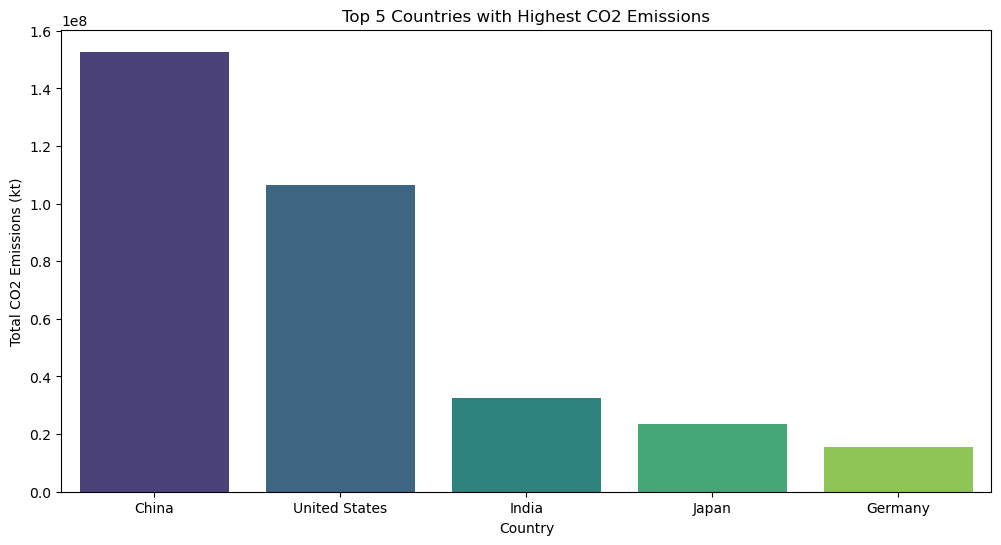

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_data = df.groupby('Entity')['Value_co2_emissions_kt_by_country'].sum()

top_countries_co2 = grouped_data.sort_values(ascending=False).head()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries_co2.index, y=top_countries_co2.values, palette='viridis')
plt.title('Top 5 Countries with Highest CO2 Emissions')
plt.ylabel('Total CO2 Emissions (kt)')
plt.xlabel('Country')
plt.show()



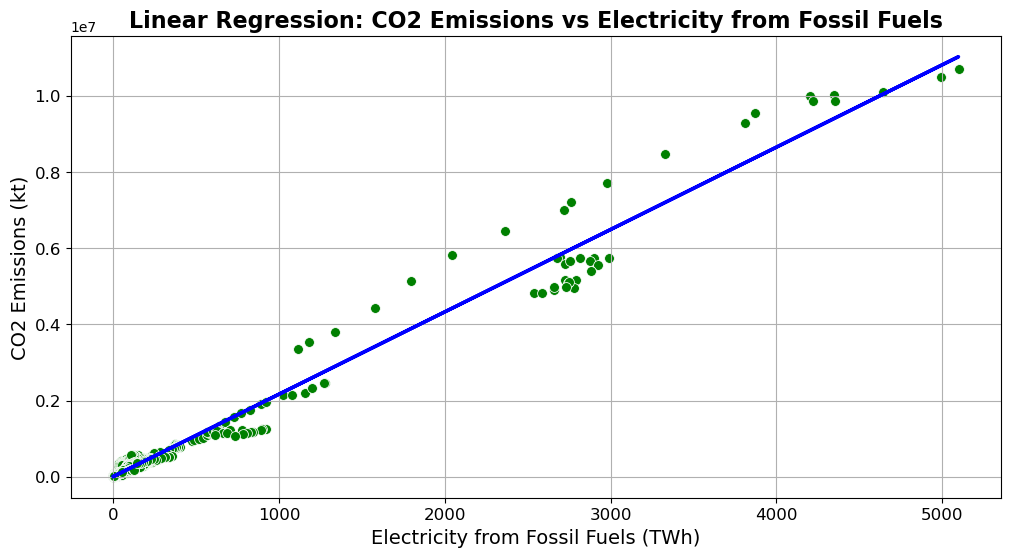

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

regression_data = df[['Electricity from fossil fuels (TWh)', 'Value_co2_emissions_kt_by_country']].dropna()

X = regression_data['Electricity from fossil fuels (TWh)'].values.reshape(-1,1)
y = regression_data['Value_co2_emissions_kt_by_country'].values
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Electricity from fossil fuels (TWh)', y='Value_co2_emissions_kt_by_country', 
                data=regression_data, color='green', s=50)  
plt.plot(X, y_pred, color='blue', linewidth=2.5)  
plt.title('Linear Regression: CO2 Emissions vs Electricity from Fossil Fuels', fontsize=16, fontweight='bold')
plt.xlabel('Electricity from Fossil Fuels (TWh)', fontsize=14)
plt.ylabel('CO2 Emissions (kt)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)  
plt.show()

In [18]:
slope, intercept = model.coef_[0], model.intercept_
slope, intercept

(2161.7950162190336, 2433.746308228903)

In [23]:
import plotly.graph_objects as go
import pandas as pd

def plot_world_map_improved(column_name, df):
    fig = go.Figure()

    for year in range(2000, 2021):
        filtered_df = df[df['Year'] == year]
        trace = go.Choropleth(
            locations=filtered_df['Entity'],
            z=filtered_df[column_name],
            locationmode='country names',
            colorscale='Viridis',  
            colorbar=dict(title=column_name),
            zmin=df[column_name].min(),
            zmax=df[column_name].max(),
            hoverinfo='location+z', 
            visible=False  
        )


        fig.add_trace(trace)

    fig.data[0].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(fig.data)},
                  {'title_text': f'{column_name} in {2000 + i}', 'frame': {'duration': 1000, 'redraw': True}}],
            label=str(2000 + i)  
        )
        step['args'][0]['visible'][i] = True  
        steps.append(step)


    sliders = [dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Year: ", "font": {"size": 14}},  
    )]


    fig.update_layout(
        title_text=f'{column_name} Map with slider',
        title_font_size=24,
        title_x=0.5,
        geo=dict(
            showframe=True,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        sliders=sliders,
        height=600,  
        width=1200,  
        font=dict(family='Arial', size=12),
        margin=dict(t=80, l=50, r=50, b=50),
        template='plotly_dark',
    )

    return fig

column_name = 'Access to electricity (% of population)'
fig = plot_world_map_improved(column_name, df)
fig.show()


In [26]:
import plotly.graph_objects as go
import pandas as pd

def plot_energy_consumption(df, column_name, top_n=5):
    fig = go.Figure()

    for year in range(2000, 2021):

        filtered_df = df[df['Year'] == year].sort_values(by=column_name, ascending=False).head(top_n)

        trace = go.Bar(
            x=filtered_df['Entity'],
            y=filtered_df[column_name],
            name=str(year),
            visible=False  
        )


        fig.add_trace(trace)

    fig.data[0].visible = True

    # Create animation steps
    steps = []
    for i, year in enumerate(range(2000, 2021)):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(fig.data)},
                  {'title': f'Top {top_n} Countries in Energy Consumption in {year}'}],
            label=str(year)
        )
        step['args'][0]['visible'][i] = True
        steps.append(step)

    sliders = [dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Year: "}
    )]

    fig.update_layout(
        title=f'Top {top_n} Countries in Energy Consumption Per Year',
        xaxis_title='Country',
        yaxis_title=column_name,
        sliders=sliders
    )

    return fig

column_name = 'Primary energy consumption per capita (kWh/person)'
fig = plot_energy_consumption(df, column_name)
fig.show()


In [27]:
import plotly.graph_objects as go
import pandas as pd

def plot_world_map_improved(column_name, df):
    fig = go.Figure()

    for year in range(2000, 2021):
        filtered_df = df[df['Year'] == year]


        trace = go.Choropleth(
            locations=filtered_df['Entity'],
            z=filtered_df[column_name],
            locationmode='country names',
            colorscale='Viridis', 
            colorbar=dict(title=column_name),
            zmin=df[column_name].min(),
            zmax=df[column_name].max(),
            hoverinfo='location+z', 
            visible=False  
        )


        fig.add_trace(trace)

    fig.data[0].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(fig.data)}, 
                  {'title_text': f'{column_name} in {2000 + i}', 'frame': {'duration': 1000, 'redraw': True}}],
            label=str(2000 + i)  
        )
        step['args'][0]['visible'][i] = True  
        steps.append(step)


    sliders = [dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Year: ", "font": {"size": 14}}, 
    )]
    fig.update_layout(
        title_text=f'{column_name} Map with slider',
        title_font_size=24,
        title_x=0.5,
        geo=dict(
            showframe=True,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        sliders=sliders,
        height=600,  
        width=1200,  
        font=dict(family='Arial', size=12),
        margin=dict(t=80, l=50, r=50, b=50),
        template='plotly_dark',
    )

    return fig


column_name = 'Access to electricity (% of population)'
fig = plot_world_map_improved(column_name, df)
fig.show()


In [37]:
import pandas as pd
import statsmodels.api as sm


grouped_data = df.groupby('Entity')['Value_co2_emissions_kt_by_country'].sum()

top_countries_co2 = grouped_data.sort_values(ascending=False).head(5)

top_countries_df = df[df['Entity'].isin(top_countries_co2.index)]

X = top_countries_df['gdp_per_capita']
y = top_countries_df['Value_co2_emissions_kt_by_country']
X = sm.add_constant(X)  

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                                    OLS Regression Results                                   
Dep. Variable:     Value_co2_emissions_kt_by_country   R-squared:                       0.039
Model:                                           OLS   Adj. R-squared:                  0.030
Method:                                Least Squares   F-statistic:                     4.025
Date:                               Mon, 01 Jan 2024   Prob (F-statistic):             0.0476
Time:                                       17:27:37   Log-Likelihood:                -1629.2
No. Observations:                                100   AIC:                             3262.
Df Residuals:                                     98   BIC:                             3268.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                     coef    std err          t      P>|t|  

In [38]:
import plotly.graph_objects as go

def plot_world_map_co2_top_countries(df, top_countries_list, column_name='Value_co2_emissions_kt_by_country'):
    fig = go.Figure()

    for year in range(2000, 2021):
        filtered_df = df[(df['Year'] == year) & (df['Entity'].isin(top_countries_list))]

        trace = go.Choropleth(
            locations=filtered_df['Entity'],
            z=filtered_df[column_name],
            locationmode='country names',
            colorscale='Reds',  
            colorbar=dict(title=column_name),
            zmin=df[column_name].min(),
            zmax=df[column_name].max(),
            text=filtered_df['gdp_per_capita'], 
            hoverinfo='location+z+text',
            visible=False  
        )


        fig.add_trace(trace)

    fig.data[0].visible = True


    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(fig.data)},
                  {'title_text': f'CO2 Emissions and GDP per Capita in {2000 + i}'}],
            label=str(2000 + i)
        )
        step['args'][0]['visible'][i] = True
        steps.append(step)


    sliders = [dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Year: "}
    )]


    fig.update_layout(
        title='CO2 Emissions for Top 5 Emitting Countries with GDP per Capita Annotations',
        geo=dict(showframe=True, showcoastlines=True, projection_type='natural earth'),
        sliders=sliders,
        template='plotly_dark'
    )

    return fig


top_countries_list = top_countries_co2.index.tolist()

fig = plot_world_map_co2_top_countries(df, top_countries_list)
fig.show()


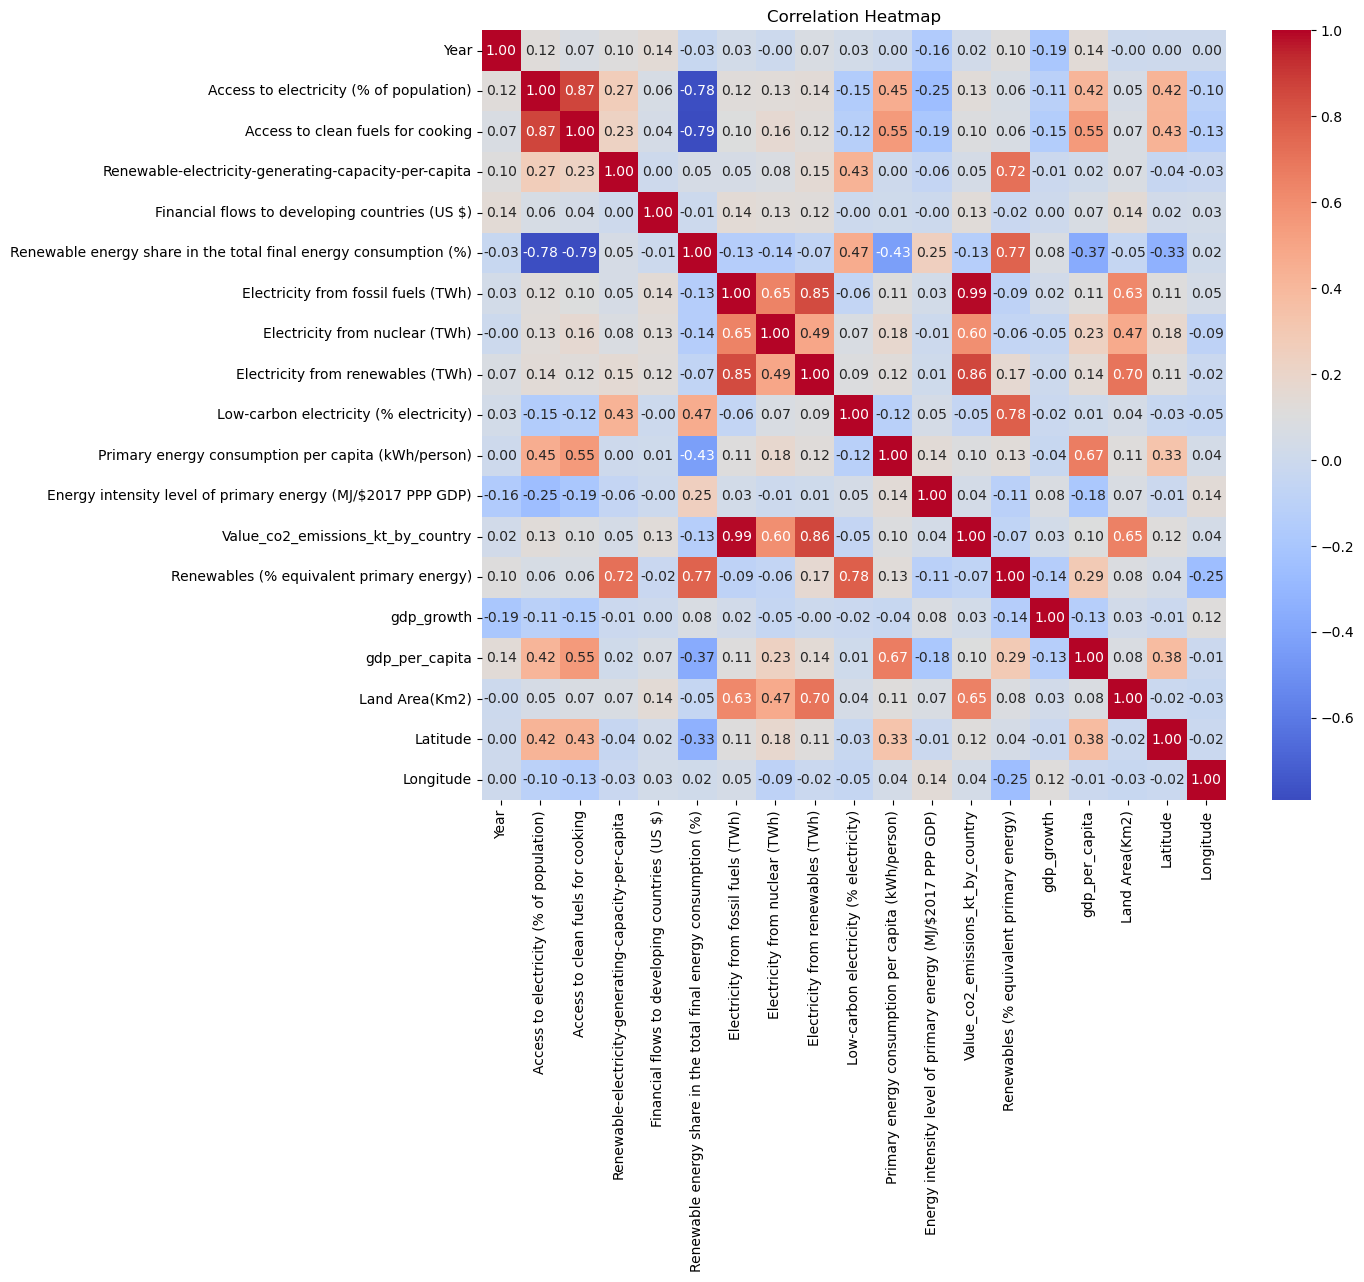

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=[np.number])


corr = numeric_df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [41]:
import numpy as np

numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

corr_matrix

Year  \
Year                                                1.000000   
Access to electricity (% of population)             0.124890   
Access to clean fuels for cooking                   0.073292   
Renewable-electricity-generating-capacity-per-c...  0.104365   
Financial flows to developing countries (US $)      0.141820   
Renewable energy share in the total final energ... -0.029384   
Electricity from fossil fuels (TWh)                 0.032615   
Electricity from nuclear (TWh)                     -0.004820   
Electricity from renewables (TWh)                   0.073935   
Low-carbon electricity (% electricity)              0.030126   
Primary energy consumption per capita (kWh/person)  0.004196   
Energy intensity level of primary energy (MJ/$2... -0.161605   
Value_co2_emissions_kt_by_country                   0.024759   
Renewables (% equivalent primary energy)            0.104767   
gdp_growth                                         -0.192566   
gdp_per_capita                                      0.135399   
Land Area(Km2)                                     -0.001629   
Latitude                                            0.003507   
Longitude                                           0.000944   

                                                    Access to electricity (% of population)  \
Year                                                                               0.124890   
Access to electricity (% of population)                                            1.000000   
Access to clean fuels for cooking                                                  0.866554   
Renewable-electricity-generating-capacity-per-c...                                 0.270423   
Financial flows to developing countries (US $)                                     0.060478   
Renewable energy share in the total final energ...                                -0.784514   
Electricity from fossil fuels (TWh)                                                0.123999   
Electricity from nuclear (TWh)                                                     0.128713   
Electricity from renewables (TWh)                                                  0.138057   
Low-carbon electricity (% electricity)                                            -0.151062   
Primary energy consumption per capita (kWh/person)                                 0.454870   
Energy intensity level of primary energy (MJ/$2...                                -0.252949   
Value_co2_emissions_kt_by_country                                                  0.126988   
Renewables (% equivalent primary energy)                                           0.058195   
gdp_growth                                                                        -0.112071   
gdp_per_capita                                                                     0.418459   
Land Area(Km2)                                                                     0.054964   
Latitude                                                                           0.420548   
Longitude                                                                         -0.102857   

                                                    Access to clean fuels for cooking  \
Year                                                                         0.073292   
Access to electricity (% of population)                                      0.866554   
Access to clean fuels for cooking                                            1.000000   
Renewable-electricity-generating-capacity-per-c...                           0.227962   
Financial flows to developing countries (US $)                               0.042204   
Renewable energy share in the total final energ...                          -0.791740   
Electricity from fossil fuels (TWh)                                          0.100752   
Electricity from nuclear (TWh)                                               0.163473   
Electricity from renewables (TWh)                                        

In [47]:
def plot_access_to_electricity_vs_gdp_map(df, year_range=(2000, 2021)):
    fig = go.Figure()

    for year in range(*year_range):
        filtered_df = df[df['Year'] == year]

        trace = go.Choropleth(
            locations=filtered_df['Entity'],
            z=filtered_df['Access to electricity (% of population)'],
            locationmode='country names',
            colorscale='Purples',
            colorbar=dict(title='Access to Electricity (%)'),
            zmin=df['Access to electricity (% of population)'].min(),
            zmax=df['Access to electricity (% of population)'].max(),
            text=filtered_df['gdp_per_capita'],
            hoverinfo='location+z+text',
            visible=(year == year_range[0])
        )

        fig.add_trace(trace)



    return fig

fig = plot_access_to_electricity_vs_gdp_map(df)
fig.show()


In [48]:
import statsmodels.api as sm

X = df[['gdp_per_capita', 'Primary energy consumption per capita (kWh/person)', 'Renewable-electricity-generating-capacity-per-capita']]
y = df['Value_co2_emissions_kt_by_country']

X = sm.add_constant(X)

model = sm.OLS(y, X, missing='drop').fit()

print(model.summary())


                                    OLS Regression Results                                   
Dep. Variable:     Value_co2_emissions_kt_by_country   R-squared:                       0.003
Model:                                           OLS   Adj. R-squared:                  0.002
Method:                                Least Squares   F-statistic:                     2.326
Date:                               Mon, 01 Jan 2024   Prob (F-statistic):             0.0729
Time:                                       17:41:37   Log-Likelihood:                -34616.
No. Observations:                               2314   AIC:                         6.924e+04
Df Residuals:                                   2310   BIC:                         6.926e+04
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
                                                           c

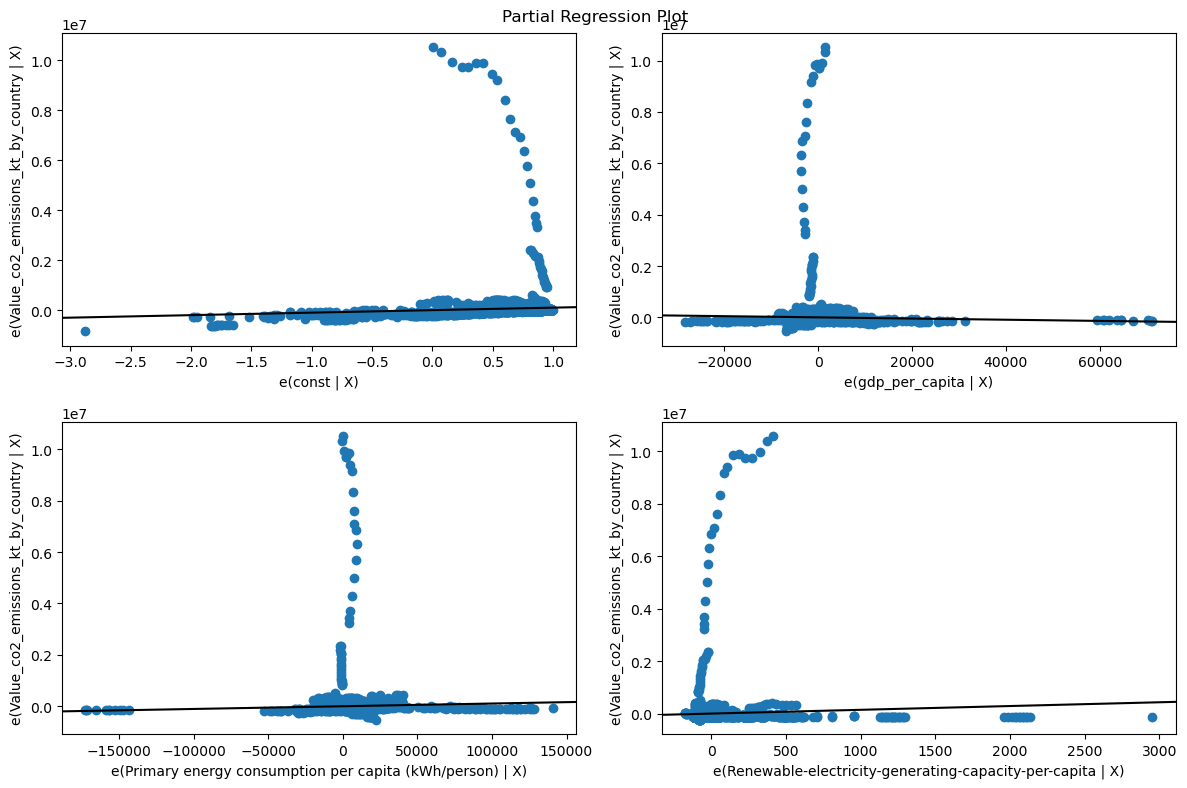

In [50]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()


In [51]:
df['CO2_Emissions_Growth'] = df.groupby('Entity')['Value_co2_emissions_kt_by_country'].pct_change()

average_growth_rate = df.groupby('Entity')['CO2_Emissions_Growth'].mean().dropna()

average_growth_rate



Entity
Afghanistan            0.144277
Albania                0.023369
Algeria                0.039179
Angola                 0.025296
Antigua and Barbuda    0.090457
                         ...   
Uruguay                0.016441
Uzbekistan            -0.001364
Vanuatu                0.060346
Zambia                 0.073292
Zimbabwe              -0.001132
Name: CO2_Emissions_Growth, Length: 163, dtype: float64

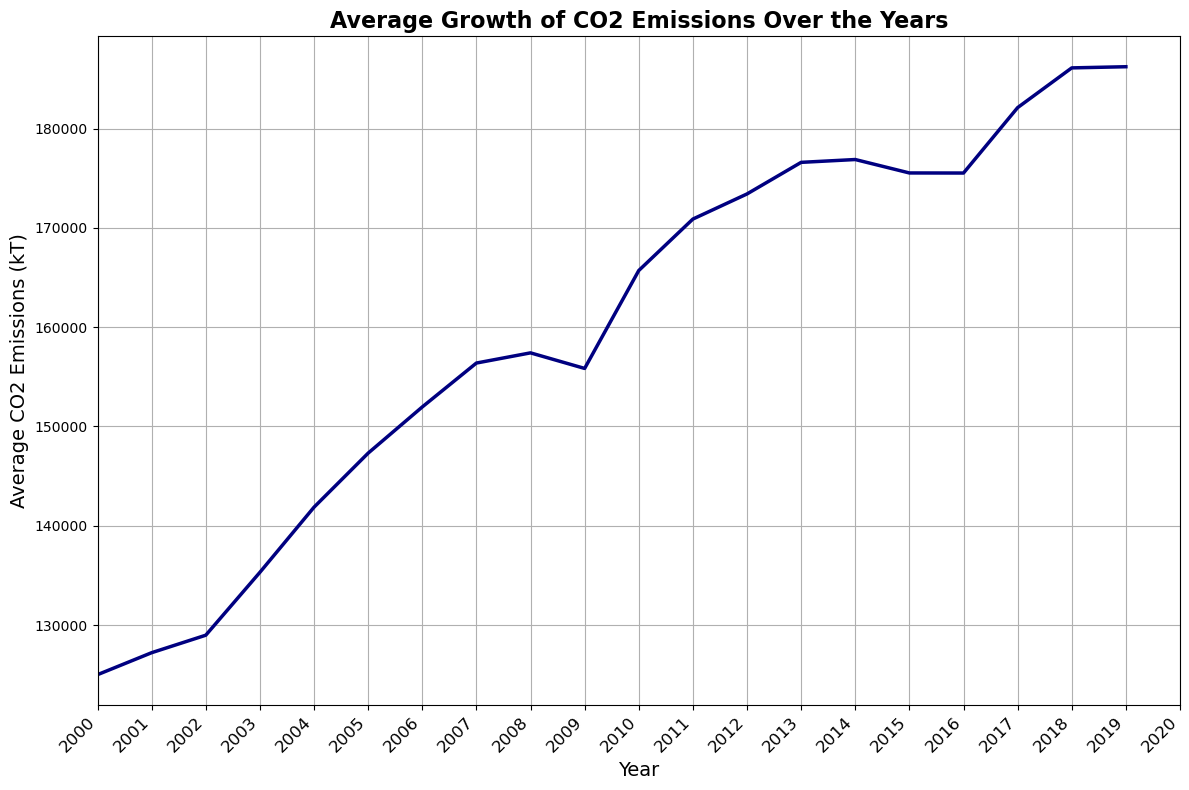

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

average_co2_by_year = df.groupby('Year')['Value_co2_emissions_kt_by_country'].mean()
average_co2_by_year = average_co2_by_year.reset_index()

plt.figure(figsize=(12, 8))

sns.lineplot(data=average_co2_by_year, x='Year', y='Value_co2_emissions_kt_by_country', color='navy', linewidth=2.5)
plt.title('Average Growth of CO2 Emissions Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average CO2 Emissions (kT)', fontsize=14)

plt.xticks(average_co2_by_year['Year'], rotation=45, ha='right', fontsize=12)
plt.xlim(average_co2_by_year['Year'].min(), average_co2_by_year['Year'].max())


plt.grid(True)
plt.tight_layout()


plt.show()

